In [19]:
from pylab import*
from numpy import*
%matplotlib inline

# Problema 3

Tenemos que la masa de la partícula será:  $m = 1$ 
Y está feliz en un campo gravitacional $\vec{g} = −9.8 \hat{j}$ 
En el dibujo de la tarea, podemos ver que la caja forma ángulos con el piso: $\alpha$ , y sus medidas son:  $L=10$ m en la tapa y $d=3$ m de los lados. 


Vamos a tomar los valores de $\alpha$ como: 

$\alpha=\pi/6 \ $ y $ \ \alpha = \pi/10$.


## a) 

velocidad inicial: $\vert \vec{v} \vert = 1$ 

ángulos $\alpha$ sobre la horizontal : $\alpha$, $2\alpha$ y $3\alpha$. 

In [20]:
def rk4j(ec,p_ini,x,args=0,h=0.01):
    #if (x[1]-x[0]) <= 5.*h:
    while (x[1]-x[0]) <= 5.*h: 
        h = (x[1]-x[0])/10
    tiempos = arange(x[0],x[1]+h,h)
    sol = zeros((len(tiempos),len(p_ini)))
    sol[0,:] = p_ini
    if args==0:
        for i in xrange(len(tiempos)-1):
            k1 = ec(sol[i,:],tiempos[i])
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h)
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h)
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h)
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
    else:
        for i in xrange(len(tiempos)-1):
            k1 = ec(sol[i,:],tiempos[i],args)
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,args)
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,args)
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,args)
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
    return tiempos,sol

La ecuación para que una pelota rebote es:

$$
m\ddot{\vec{a}} = -g \hat{j}
$$

Separándola en coordenadas sería:

$$
\ddot{x} =0
$$

$$
\ddot{y} + \frac{g}{m} = 0
$$

Entonces, las ecuaciones de movimiento quedarían como:

In [21]:
#rv=[x,y,vx,vy]
def ecuacion_mov(rv, t ,fric = 0., g=9.81 ,m=1):
    
    u = sqrt(rv[2]**2 + rv[3]**2) #norma
    dx= rv[2] #vel en x
    dy= rv[3] #vel en y
    
    if fric == 0. : 
        dvx= 0
        dvy= -g/m
    
    else: #para considerar los casos en los que tengamos friccion de una vez y no tener que programar otra ecuacion:
        dvx = -fric([rv[2], rv[3]])[0]
        dvy = -g/m -fric([rv[2], rv[3]])[1]
    
    return array([dx,dy,dvx,dvy])

La caja: 

Se supone que la caja es simétrica. Los ángulos que se van a utilizar serán $\pi/6 $ y $\pi / 10$ 

In [22]:
#Mejor la definimos de una vez y cuando la queramos poner en las graficas la mandamos llamar, en vez de andarla 
#ploteando siempre desde cero. 

def plano(x,angulo):
    return -tan(angulo*pi/180.)*x

def techo(x,angulo):
    y = zeros(len(x))
    a = 5*tan(angulo*pi/180.)
    y[:] = a + 3
    return y

def pared(pt, angulo):
    a = 5*tan(angulo*pi/180.)
    y = arange(a,a+3,.01)
    x = zeros(len(y))
    x[:] = pt
    return array([x,y])

def caja(x,angulo):
    ang = angulo
    pt_i = x[0]
    pt_f = x[-1]
    
    p = -plano(abs(x), ang)
    t = techo(x, ang)
    der = pared(pt_i,ang)
    izq = pared(pt_f,ang)
    
    return plot(x,p[:], x,t[:], der[0,:],der[1,:], izq[0,:],izq[1,:], color = 'grey',linewidth=4)

Ahora vamos a definir el rebote con las paredes y el piso: 
Primero sabemos que el ángulo a la hora de rebotar en los planos inclinados van a variar las componentes de la velocidad entonces debemos definir un cambio de coordenadas (una rotación) para obtener la componente de la velocidad después del rebote. Además, para el caso en el que rebota en la pared izquierda se va a utilizar $\alpha$ y si cae en la derecha $-\alpha$. 

La rotación estará dada por: 
\begin{align}
\left(\begin{array}{c} x' \\ y' \\ \dot{x'} \\ \dot{y'} \end{array} \right) = \left(\begin{array}{cccc} 1 & 0 & 0 & 0  \\ 0 & 1 & 0 & 0 \\ 0 & 0 & cos(\theta) & -sen(\theta) \\ 0 & 0 & sen(\theta) & cos(\theta) \end{array}\right) \left(\begin{array}{c} x \\ y \\ \dot{x} \\ \dot{y} \end{array} \right) 
\end{align}

In [35]:
def rotacion_vel(angulo):
    angulo = angulo*pi/180.
    return array([1,0,0,0]),array([0,1,0,0]),array([0,0,cos(angulo),-sin(angulo)]),array([0,0,sin(angulo),cos(angulo)])

En la tarea 2 utilizamos una funcion que nos rotaba las componentes de la velocidad en el momento en el que chocaba contra una pared (encontraba una raiz). Entonces utilizaremos esa misma función para el rebote de este caso (rebote). 

Para el caso del rebote con el techo no es necesario hacer ninguna rotación ya que la componente y se reflejará por completo. 

Para las paredes, tenemos que ubicar en que punto de la pared se encuentra al rebotar y con eso saber cómo se reflejará la velocidad. 

In [36]:
#Sacada del problema 3 de mi tarea 2 (también en github)

def rebote(r_v_i,mi_dt,ang,modelo_fric=0):
    
    dt_busqueda = mi_dt/2
    y_izq = r_v_i
    t,sol = rk4j(ecuacion_mov,r_v_i,[0,dt_busqueda],modelo_fric)
    y_med = sol[-1,:]

    while abs(y_izq[1]-plano(y_izq[0],ang))>1e-5:
        if (y_izq[1]-plano(y_izq[0],ang))*(y_med[1]-plano(y_med[0],ang))<0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t, sol = rk4j(ecuacion_mov, reinicio,[0,dt_busqueda],modelo_fric)
        y_izq = reinicio
        y_med = sol[-1,:]
    y_izq = dot(rotacion_vel(ang),y_izq)
    y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
    return y_izq

#Rebote con el techo: 

def rebote_techo(r_v_i,mi_dt,ang,modelo_fric=0):
    dt_busqueda = mi_dt/2
    y_izq = r_v_i
    t,sol = rk4j(ecuacion_mov,r_v_i,[0,dt_busqueda],modelo_fric)
    y_med = sol[-1,:]
    tope_y = 3 + 5*tan(angulo*pi/180.)

    while abs(y_izq[1]-tope_y)>1e-5:
        if (y_izq[1]-tope_y)*(y_med[1]-tope_y)<0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t, sol = rk4j(ecuacion_mov, reinicio,[0,dt_busqueda],modelo_fric)
        y_izq = reinicio
        y_med = sol[-1,:]
    y_izq = dot(rotacion_vel(ang),y_izq)
    y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
    return y_izq

#Rebote con la pared: 
def rebote_pared(r_v_i,mi_dt,modelo_fric=0):
    dt_busqueda = mi_dt/2
    y_izq = r_v_i
    t,sol = rk4j(ecuacion_mov,r_v_i,[0,dt_busqueda],modelo_fric)
    y_med = sol[-1,:]
    pared = sign(y_izq[0])*5

    while abs(y_izq[0]-pared)>1e-5:
        if (y_izq[0]-pared)*(y_med[0]-pared)<0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t, sol = rk4j(ecuacion_mov, reinicio,[0,dt_busqueda],modelo_fric)
        y_izq = reinicio
        y_med = sol[-1,:]
        pared = sign(y_izq[0])*5
    y_izq = array([y_izq[0],y_izq[1],-y_izq[2],y_izq[3]])
    return y_izq

Ahora hay que definir las condiciones del rebote para saber cuándo rebota en qué pared: 

- Utilizamos la funcion "rebote" con dos disintos ángulos ($\alpha$ y $-\alpha$ ): 
        - si $x<0$ entonces utilizaremos $\alpha$
        - si $x>0$ entonces utilizaremos $-\alpha$
        
- Si se cumple que $\vert x \vert > 5 $ entonces entra a la función "rebote_pared"
- Por último, si la altura es mayor que el valor del techo, entrará a "rebote_techo"

Con esto tendremos entonces la trayectoria de la pelota:

In [37]:
equis = arange(-5,5,.01)

In [38]:
def datos_graf(cond_ini, ang, modelo_fric=0,pts=100, dt=0.1):
    N = pts
    inicio = cond_ini
    trayectoria = zeros((N,len(inicio)))
    mi_dt = dt
    trayectoria[0,:] = array(inicio)
    tope_y = 3 + 5*tan(angulo*pi/180.)
    
    for i in range(N-1):
        t,sol_dt = rk4j(ecuacion_mov,trayectoria[i,:],[0,mi_dt], modelo_fric)
    
        if sol_dt[-1,:][0]<=0 and sol_dt[-1,:][1]-plano(sol_dt[-1,:][0], ang) < 0:
            y_izq = rebote(trayectoria[i,:],mi_dt,ang)    
            trayectoria[i+1,:] = y_izq
        elif sol_dt[-1,:][0] > 0 and sol_dt[-1,:][1]-plano(sol_dt[-1,:][0], -ang) < 0:
            y_izq = rebote(trayectoria[i,:],mi_dt,-ang)    
            trayectoria[i+1,:] = y_izq
        elif sol_dt[-1,:][1] >= tope_y:
            y_izq = rebote_techo(trayectoria[i,:],mi_dt,0)    
            trayectoria[i+1,:] = y_izq
        elif 5 <= abs(sol_dt[-1,:][0]):
            y_izq = rebote_pared(trayectoria[i,:],mi_dt,0)    
            trayectoria[i+1,:] = y_izq
        else:
            trayectoria[i+1,:] = sol_dt[-1,:]
    return trayectoria


## a)

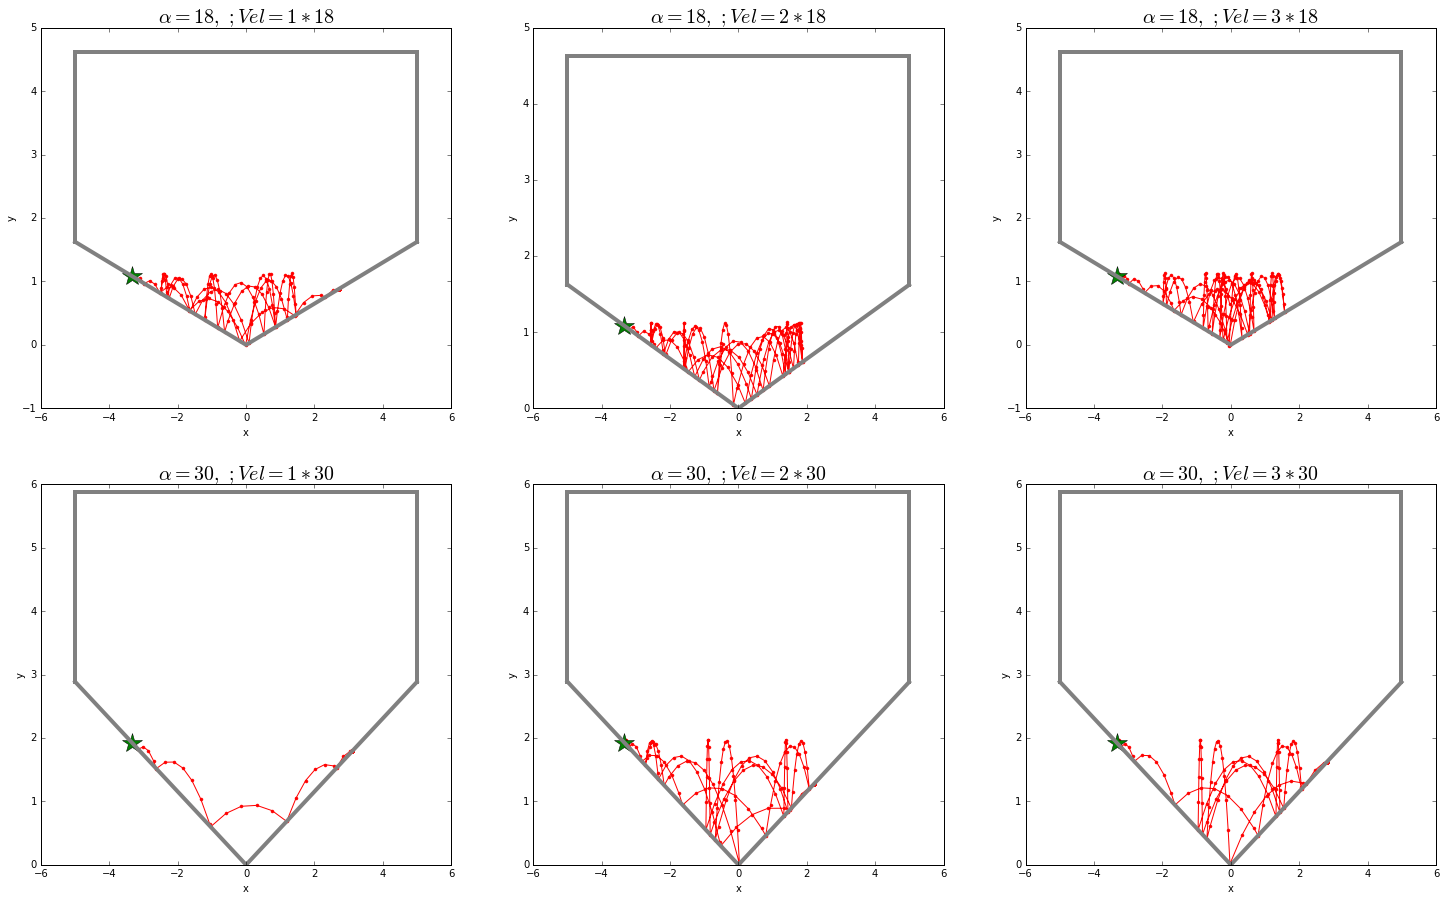

In [39]:
#la estrella es donde inicia la trayectoria
angulos = [18,30]
variacion = [1,2,3]

fig, ax = plt.subplots(figsize=(25,15 ))

n = 1
for i in xrange(len(angulos)):
    angulo = angulos[i]

    for j in variacion:
        inicio = [-10./3,10.*tan(angulo*pi/180)/3, cos(j*angulo*pi/180), sin(j*angulo*pi/180)]
        trayectoria = datos_graf(inicio,angulo,0,200)
        
        subplot(2,3, n) #no es lo mismo ponerle el n=1 directamente ahi porque entonces no las separa
                        #y cuando intenté con ix.subplot como que se ponía de mal humor o algo y no jalaba
        
        title(r'$\alpha = %s\ ; Vel=  %s$' %(str(angulos[i])+',',str(j)+'*'+str(angulos[i])),fontsize = 20),xlabel('x'),ylabel('y')
        plot(trayectoria[:,0],trayectoria[:,1],'.-',color = 'red')
        plot(inicio[0],inicio[1],'*',color = "green", markersize=20 )
        caja(equis, angulo)
        n +=1
show()
#Variamos la velocidad en función del ángulo y un parámetro de variación que nos da múltiplos del ángulo.

## c) 
(la parte sin fricción)

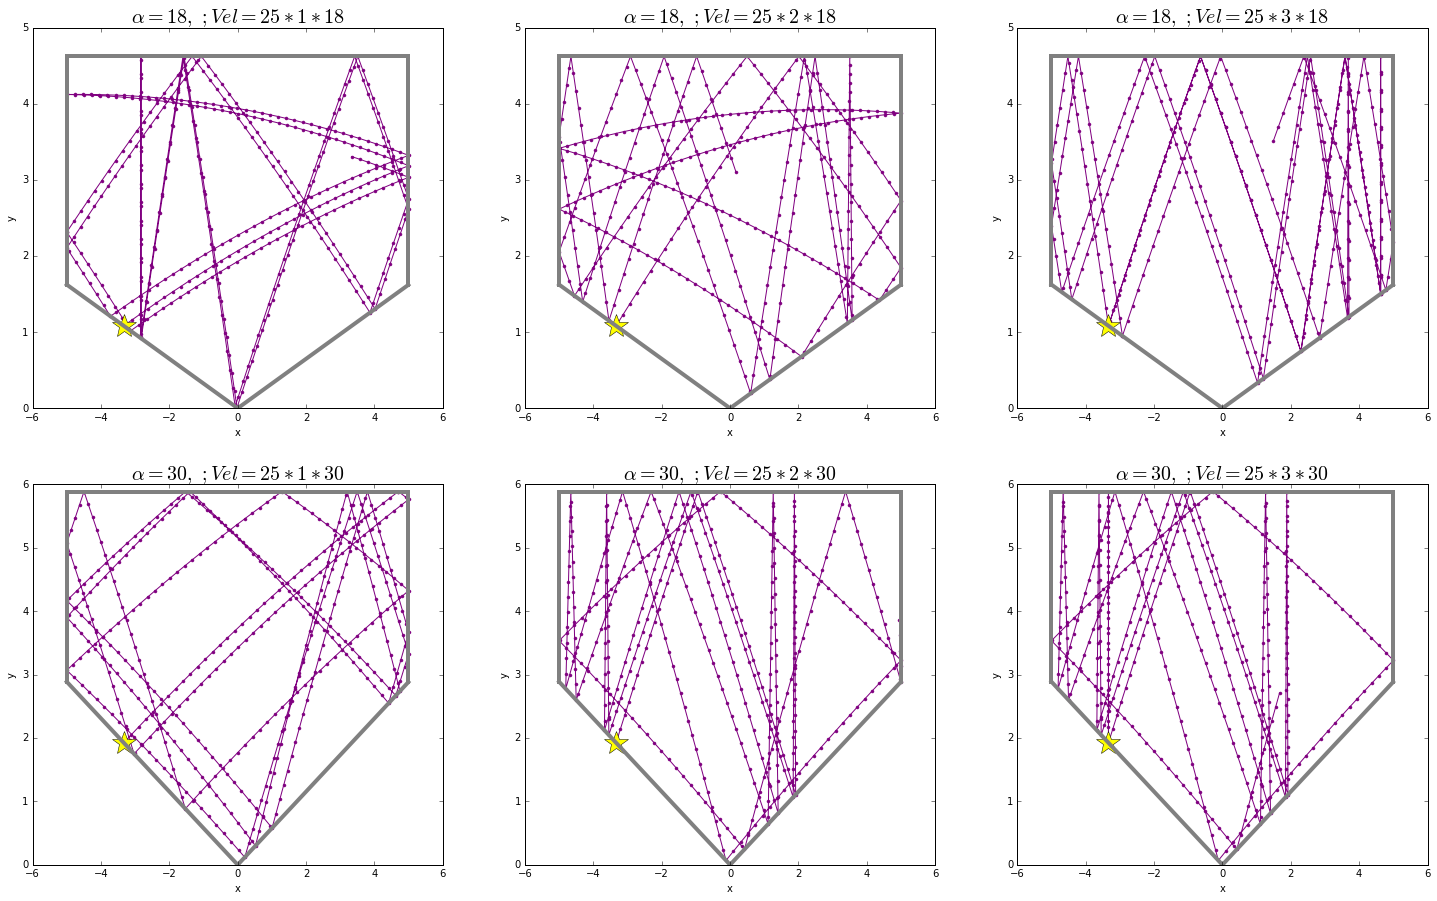

In [40]:
#Norma de la velocidad = 25
angulos = [18,30]
variacion = [1,2,3]

fig, ax = plt.subplots(figsize=(25,15 ))

n = 1
for i in xrange(len(angulos)):
    angulo = angulos[i]

    for j in variacion:
        inicio = [-10./3,10.*tan(angulo*pi/180)/3, 25*cos(j*angulo*pi/180), 25*sin(j*angulo*pi/180)]
        trayectoria = datos_graf(inicio,angulo,0,500,.01)
        
        subplot(2,3, n)
        title(r'$\alpha = %s\ ; Vel=  25*%s$' %(str(angulos[i])+',',str(j)+'*'+str(angulos[i])),fontsize = 20),xlabel('x'),ylabel('y')
        plot(trayectoria[:,0],trayectoria[:,1],'.-',color = 'purple')
        plot(inicio[0],inicio[1],'*',color='yellow',markersize=25)
        caja(equis, angulo)
        n +=1
show()

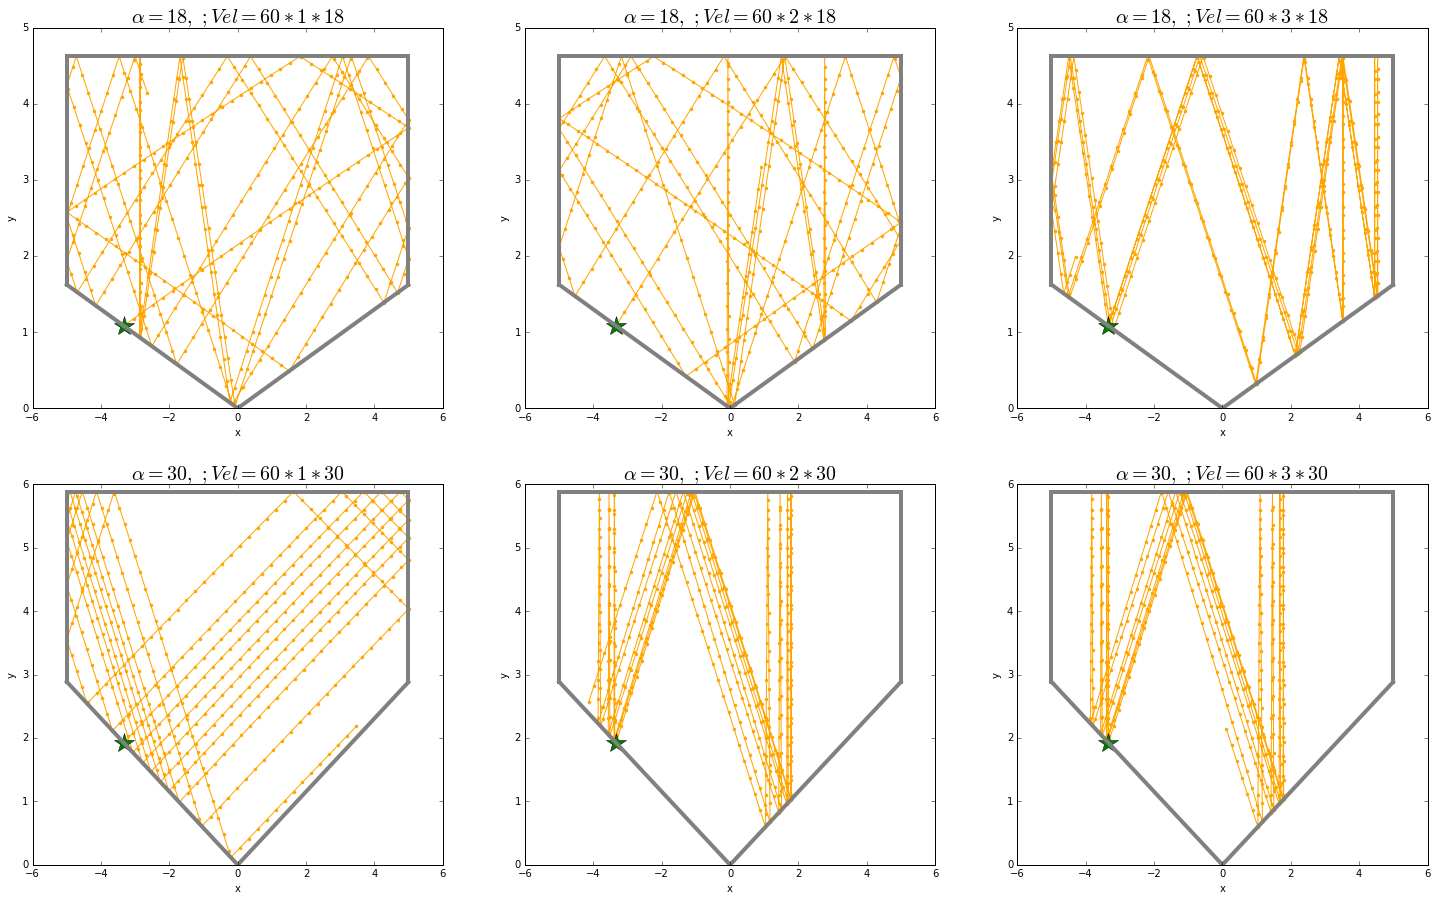

In [41]:
#Norma de la velocidad = 60

angulos = [18,30]
variacion = [1,2,3]

fig, ax = plt.subplots(figsize=(25,15 ))

n = 1
for i in xrange(len(angulos)):
    angulo = angulos[i]

    for j in variacion:
        inicio = [-10./3,10.*tan(angulo*pi/180)/3, 60*cos(j*angulo*pi/180), 60*sin(j*angulo*pi/180)]
        trayectoria = datos_graf(inicio,angulo,0,500,.1/20)
        
        subplot(2,3, n)
        title(r'$\alpha = %s\ ; Vel= 60* %s$' %(str(angulos[i])+',',str(j)+'*'+str(angulos[i])),fontsize = 20),xlabel('x'),ylabel('y')
        plot(trayectoria[:,0],trayectoria[:,1],'.-',color = 'orange')
        plot(inicio[0],inicio[1],'*',color='green',markersize=20)
        caja(equis, angulo)
        n +=1
show()

Si nos fijamos en las 6 gráficas para cada una de las tres velocidades podemos notar que el rebote se va haciendo mas "brusco" a medida que la velocidad aumenta. Tiene sentido porque llega a las paredes con mayor velocidad y por lo tanto hay mayor energía cinética, lo que hace que las trayectorias entre pared y pared sean más rectas entre mayor en la velocidad. 

## b) 

Ya introducimos el modelo de fricción a nuestra ecuación de movimiento, lo único que vamos a hacer es poner el modelo de fricción: 

In [42]:
#Modelo de friccion :

def fricv(v, gamma = 0.5):
    
    f_x = gamma*v[0]
    f_y = gamma*v[1]
    return array([f_x,f_y])

In [43]:
def datos_graf_f(cond_ini, ang, modelo_fric ,pts=100, dt=0.01):
    N = pts
    inicio = cond_ini
    trayectoria = zeros((N,len(inicio)))
    mi_dt = dt
    trayectoria[0,:] = array(inicio)
    tope_y = 3 + 5*tan(angulo*pi/180.)
    modelo_fric = fricv #lo único que hicimos es agregar aquí el modelo de fricción
                        #no hace falta hacer nada mas porque la ecuacion de movimiento
                        #ya contempla al modelo de fricción
    
    for i in range(N-1):
        t,sol_dt = rk4j(ecuacion_mov,trayectoria[i,:],[0,mi_dt], modelo_fric)
    
        if sol_dt[-1,:][0]<=0 and sol_dt[-1,:][1]-plano(sol_dt[-1,:][0], ang) < 0:
            y_izq = rebote(trayectoria[i,:],mi_dt,ang)    
            trayectoria[i+1,:] = y_izq
        elif sol_dt[-1,:][0] > 0 and sol_dt[-1,:][1]-plano(sol_dt[-1,:][0], -ang) < 0:
            y_izq = rebote(trayectoria[i,:],mi_dt,-ang)    
            trayectoria[i+1,:] = y_izq
        elif sol_dt[-1,:][1] >= tope_y:
            y_izq = rebote_techo(trayectoria[i,:],mi_dt,0)    
            trayectoria[i+1,:] = y_izq
        elif 5 <= abs(sol_dt[-1,:][0]):
            y_izq = rebote_pared(trayectoria[i,:],mi_dt,0)    
            trayectoria[i+1,:] = y_izq
        else:
            trayectoria[i+1,:] = sol_dt[-1,:]
    return trayectoria

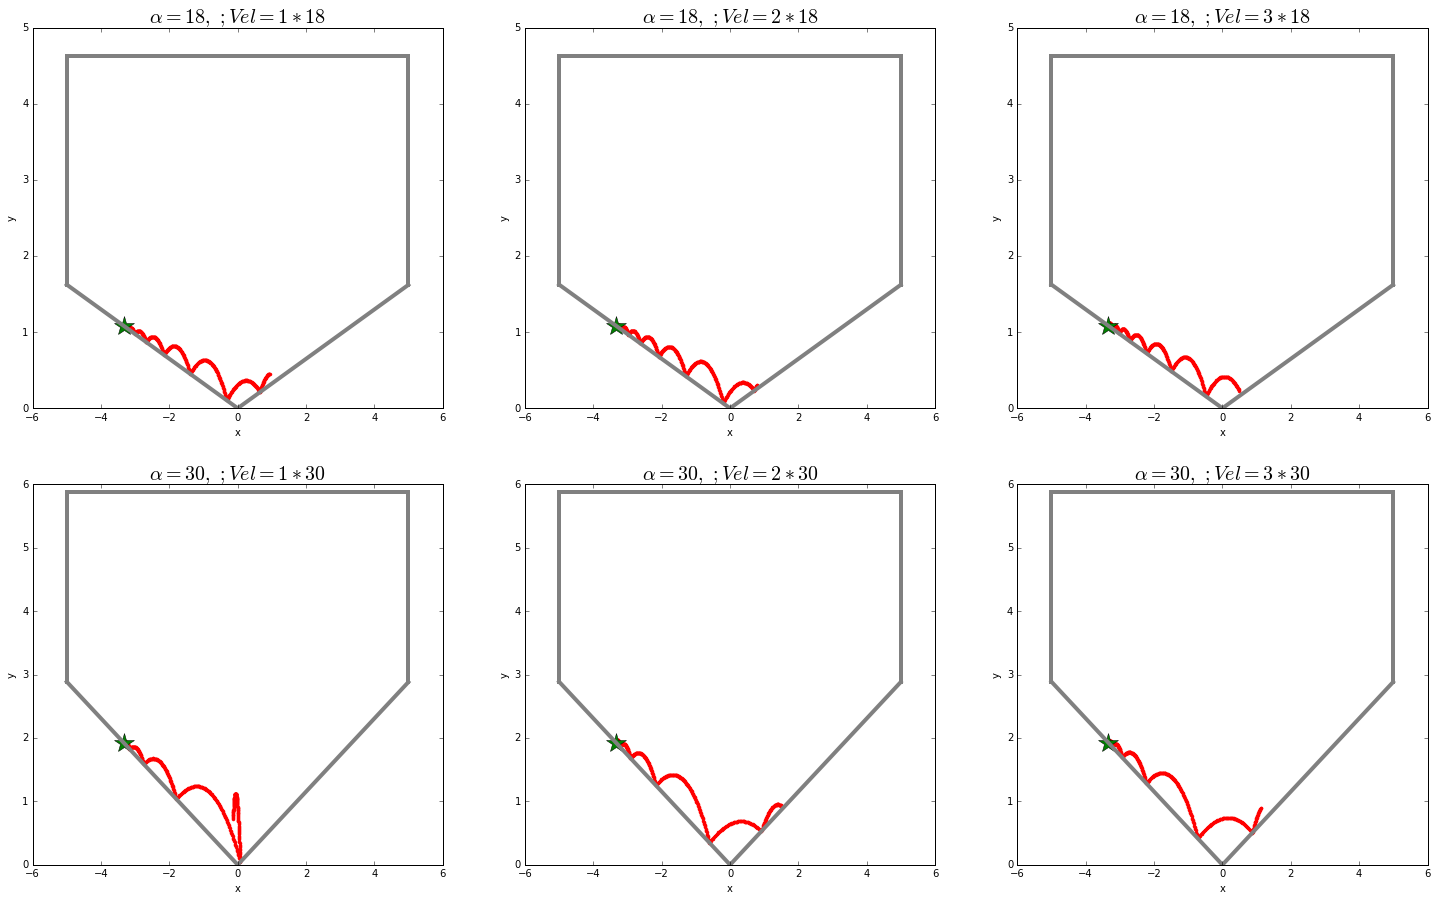

In [44]:
angulos = [18,30]
variacion = [1,2,3]

fig, ax = plt.subplots(figsize=(25,15 ))

n = 1
for i in xrange(len(angulos)):
    angulo = angulos[i]

    for j in variacion:
        inicio = [-10./3,10.*tan(angulo*pi/180)/3, cos(j*angulo*pi/180), sin(j*angulo*pi/180)]
        trayectoria = datos_graf_f(inicio,angulo,0,500,.1/20)
        
        subplot(2,3, n)
        title(r'$\alpha = %s\ ; Vel=%s$' %(str(angulos[i])+',',str(j)+'*'+str(angulos[i])),fontsize = 20),xlabel('x'),ylabel('y')
        plot(trayectoria[:,0],trayectoria[:,1],'.',color = 'red')
        plot(inicio[0],inicio[1],'*',color='green',markersize=20)
        caja(equis, angulo)
        n +=1
show()

## c) 
(los casos con fricción)

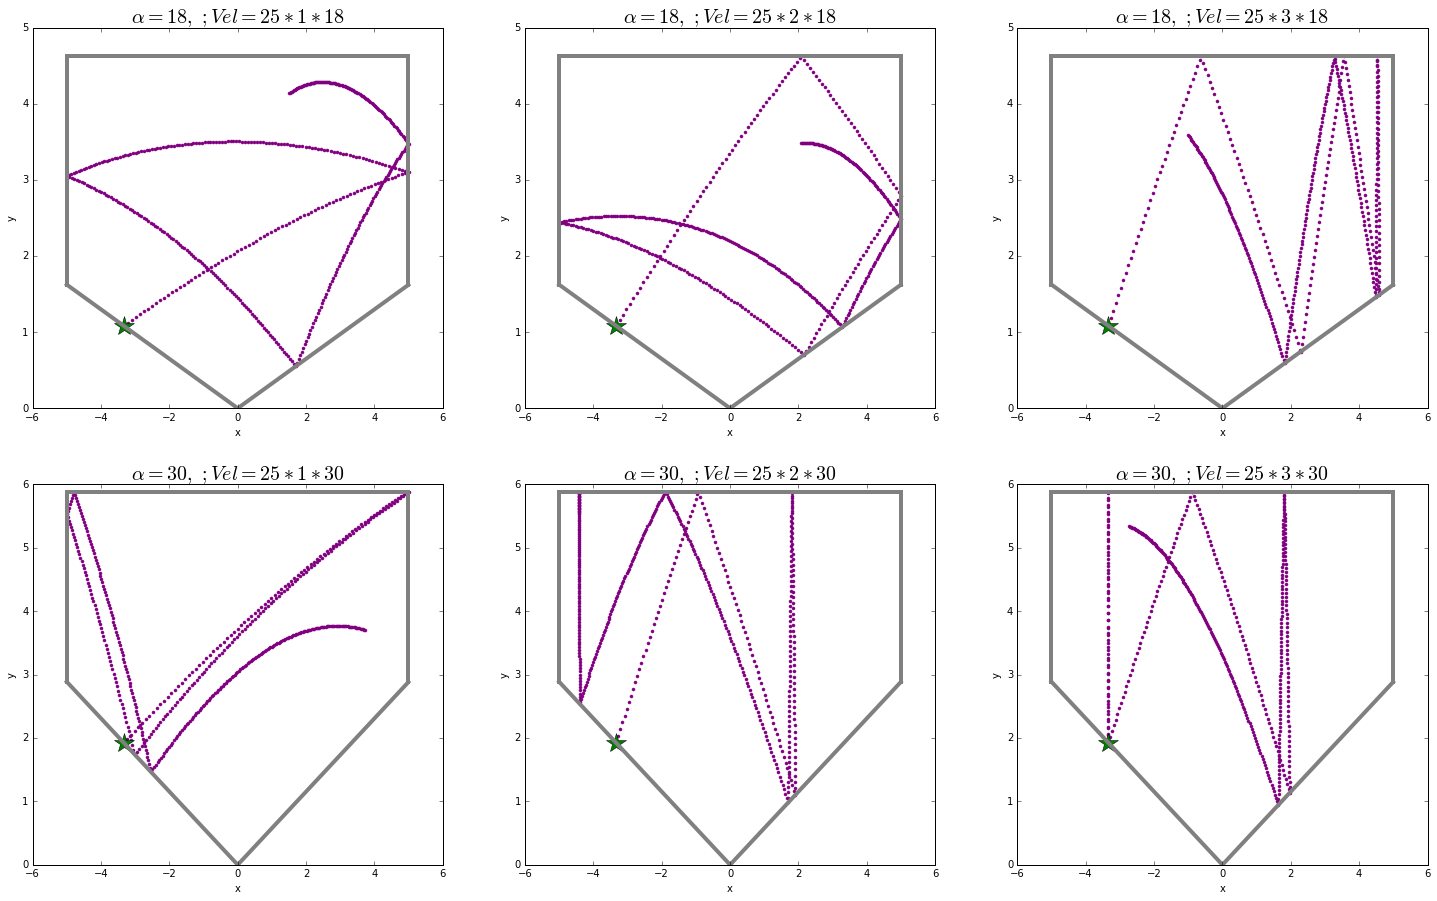

In [45]:
#Norma de la velocidad = 25
angulos = [18,30]
variacion = [1,2,3]

fig, ax = plt.subplots(figsize=(25,15 ))

n = 1
for i in xrange(len(angulos)):
    angulo = angulos[i]

    for j in variacion:
        inicio = [-10./3,10.*tan(angulo*pi/180)/3, 25*cos(j*angulo*pi/180), 25*sin(j*angulo*pi/180)]
        trayectoria = datos_graf_f(inicio,angulo,0,500,.1/20)
        
        subplot(2,3, n)
        title(r'$\alpha = %s\ ; Vel= 25*%s$' %(str(angulos[i])+',',str(j)+'*'+str(angulos[i])),fontsize = 20),xlabel('x'),ylabel('y')
        plot(trayectoria[:,0],trayectoria[:,1],'.',color = 'purple')
        plot(inicio[0],inicio[1],'*',color='green',markersize=20)
        caja(equis, angulo)
        n +=1
show()

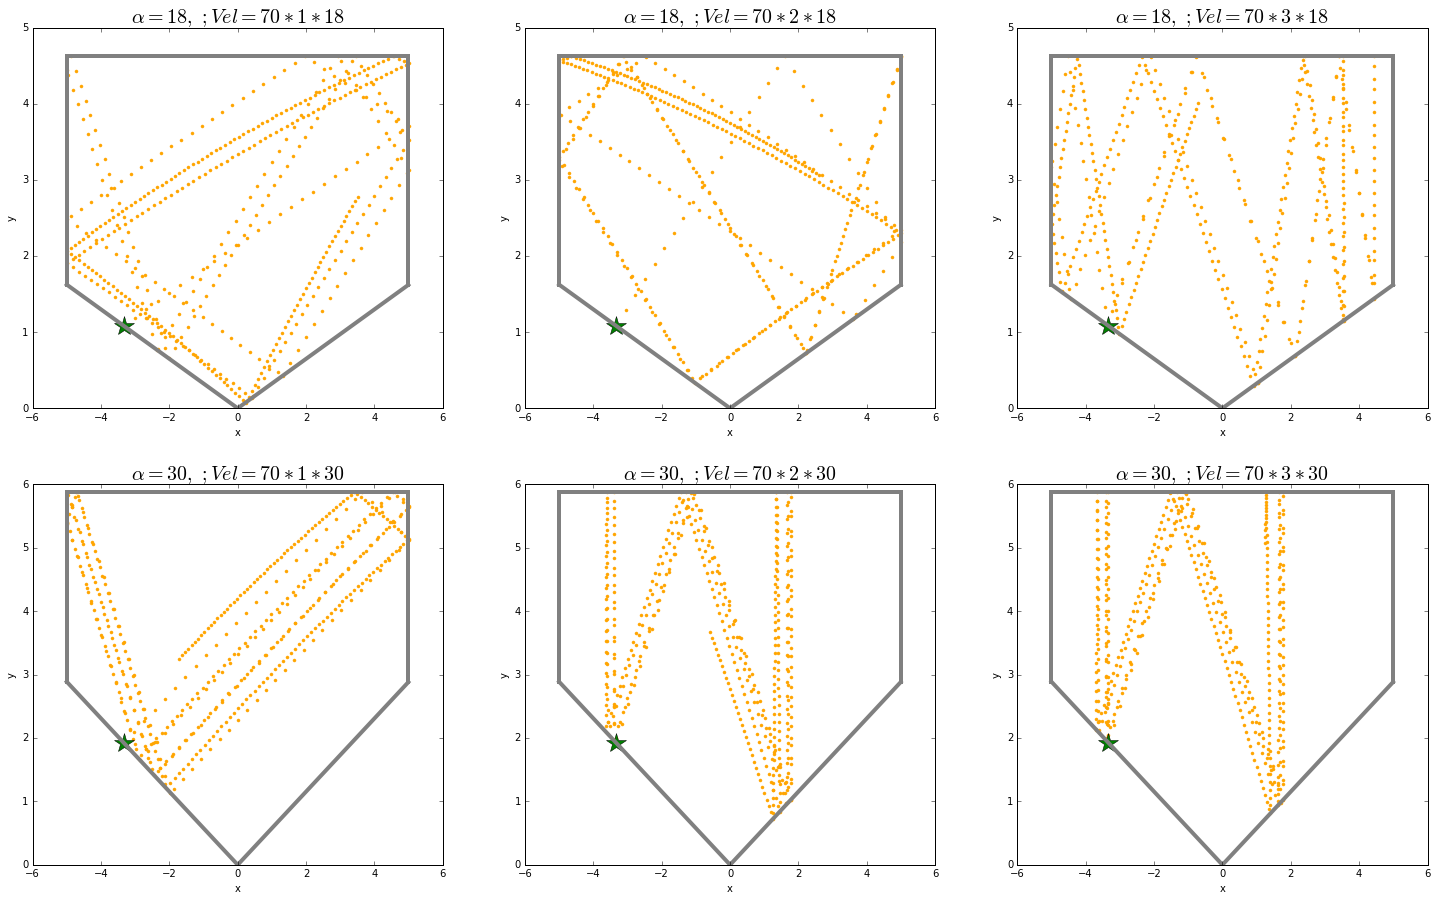

In [46]:
#Norma de la velocidad = 25
angulos = [18,30]
variacion = [1,2,3]

fig, ax = plt.subplots(figsize=(25,15 ))

n = 1
for i in xrange(len(angulos)):
    angulo = angulos[i]

    for j in variacion:
        inicio = [-10./3,10.*tan(angulo*pi/180)/3, 70*cos(j*angulo*pi/180), 70*sin(j*angulo*pi/180)]
        trayectoria = datos_graf_f(inicio,angulo,0,500,.1/20)
        
        subplot(2,3, n)
        title(r'$\alpha = %s\ ; Vel= 70*%s$' %(str(angulos[i])+',',str(j)+'*'+str(angulos[i])),fontsize = 20),xlabel('x'),ylabel('y')
        plot(trayectoria[:,0],trayectoria[:,1],'.',color = 'orange')
        plot(inicio[0],inicio[1],'*',color='green',markersize=20)
        caja(equis, angulo)
        n +=1
show()

De nuevo podemos ver como las traectorias en el caso que tiene mayor velocidad son rectas y la fricción casi no tiene efecto, mientras que en la velocidad = 1 vemos como el movimiento se atenúa rápidamente. 

Como nota, para esta parte de fricción se escogió que los puntos de la trayectoria fueran sólo puntos y así es más clara la visualización de cuando la fricción está actuando ya que se ve la separación entre los puntos. 

## d) espacio fase

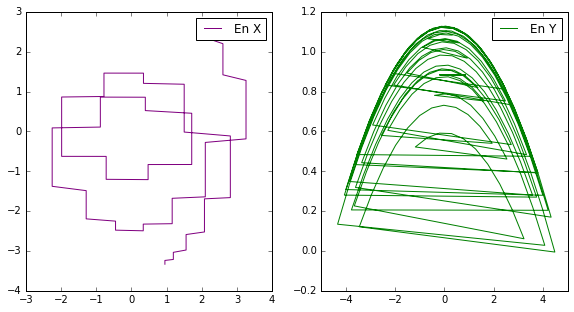

In [60]:
#sin fricción:

fig, ax = plt.subplots(figsize=(15,5))

angulo = 18
inicio = [-10./3,10.*tan(angulo*pi/180)/3, cos(angulo*pi/180), sin(angulo*pi/180)]
trayectoria = datos_graf(inicio,angulo,0,1000,1./20.)

#momento contra x
subplot(1,3, 2)
plot(trayectoria[:,2],trayectoria[:,0],'-',color = 'purple' , label = 'En X')
legend()


#momento contra y
subplot(1,3, 3)
plot(trayectoria[:,3],trayectoria[:,1],'-',color = 'green', label = 'En Y')

legend()
show()

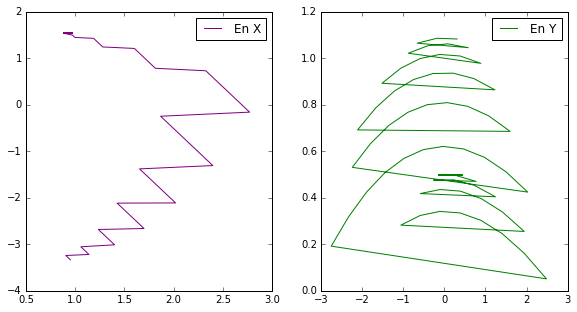

In [61]:
#con fricción:

fig, ax = plt.subplots(figsize=(15,5))

angulo = 18
inicio = [-10./3,10.*tan(angulo*pi/180)/3, cos(angulo*pi/180), sin(angulo*pi/180)]
trayectoria = datos_graf_f(inicio,angulo,0,1000,1./20.)

#momento contra x
subplot(1,3, 2)
plot(trayectoria[:,2],trayectoria[:,0],'-',color = 'purple' , label = 'En X')
legend()


#momento contra y
subplot(1,3, 3)
plot(trayectoria[:,3],trayectoria[:,1],'-',color = 'green', label = 'En Y')

legend()
show()